In [1]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import stats
from scipy.interpolate import interp1d

In [2]:
class BG_Calibrater:      #medianフィルター未実装
    def __init__(self, image, savgol_window=31, savgol_polyorder=2, apply_median=True):
        self.image = image
        self.savgol_window = savgol_window
        self.savgol_polyorder = savgol_polyorder
        self.apply_median = apply_median
        self.calibrated_image = None

    def __call__(self):
        '''
        -------------------処理の流れ-------------------
        外れ値の抽出
        バックグラウンドのみ抽出
        取り除いた外れ値の部分を線形補完
        savgolフィルターによる近似曲線抽出
        元データ-近似曲線でベースラインの補正
        必要であればメディアンフィルターの適用
        補正後の画像を出力
        （途中で各種のパラメーターを属性として保存）
        ------------------------------------------------
        これクラスメソッドにした方が良いのか？
        そもそも特殊メソッドをクラスメソッドにできるのか知らんけど
        '''
        thresholds_low, thresholds_high = self._get_thresholds(self.image)
        background_filter = self._get_background_filter(self.image, thresholds_low, thresholds_high)
        background_splined = self._get_splined_background(self.image, background_filter)
        background_smoothed = self._savgol_smoothing(background_splined, self.savgol_window, self.savgol_polyorder)
        image_calibrated = self.image - background_smoothed
        if self.apply_median == True:
            image_caribrated = cv2.medianBlur(image_calibrated.astype(np.float32), ksize=3)
        self.calibrated_image = image_calibrated
        return image_calibrated


    @staticmethod
    def _get_thresholds(image):      #各行の外れ値の閾値を取得（2次元array）
        weight_q1 = stats.scoreatpercentile(image, 25, axis=1).reshape((image.shape[0], 1))
        weight_q3 = stats.scoreatpercentile(image, 75, axis=1).reshape((image.shape[0], 1))
        weight_iqr = weight_q3 - weight_q1
        thresholds_low = weight_q1 - (weight_iqr) * 1.5
        thresholds_high =  weight_q3 + (weight_iqr)* 0          #*0であってる？
        return thresholds_low, thresholds_high
    
    @staticmethod
    def _get_background_filter(image, thresholds_low, thresholds_high):
        background_filter = (image > thresholds_low) & (image < thresholds_high)
        background_filter[:,0] = True
        background_filter[:,-1] = True    #画像の端をTrueにしておかないと次の補完でエラーになる
        return background_filter

    @staticmethod
    def _get_splined_background(image, background_filter):   #欠損しているバックグラウンドの補完
        splined_bg = np.empty(image.shape)
        n_row, n_column = image.shape
        for i in range(n_row):
            filter_row = background_filter[i]
            background_x, *_ = np.where(filter_row)
            background_height = image[i][filter_row]
            f = interp1d(background_x, background_height)
            x = np.arange(n_column)  #画像の横一列のピクセル番号（0～1023）
            splined_bg[i] = f(x)
        return  splined_bg  

    @staticmethod
    def _savgol_smoothing(background_splined, window_length, polyorder):
        def savgol(row, wl=window_length, po=polyorder):
            return savgol_filter(row, wl, po)
        bg_smoothed = np.apply_along_axis(savgol, 1, background_splined)
        return bg_smoothed
        
        

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import canny
from skimage.filters import threshold_local
from skimage.morphology import  binary_opening, binary_closing, binary_erosion, binary_dilation
from skimage.transform import probabilistic_hough_line

class Segmentater:    #クッソ遅い（どこが遅いかは調べてないが、多分ラベリングとハフ変換）。本当にハフ変換必要なのか
    def __init__(self, calibrated_image, global_threshold=0.3, wsize_localbin=17, area_min=200, area_min2=200, H_length=12, H_Sratio=0.3):
        self.image = calibrated_image
        self.global_threshold = global_threshold
        self.wsize_localbin = wsize_localbin
        self.area_min = area_min
        self.area_min2 = area_min2
        self.H_length = H_length
        self.H_Sratio = H_Sratio
        
        self.binary_image = None
        self.no_linear = None

    def __call__(self):
        '''
        -------------processing flow-----------------
        1. binary_global
        2. binary_local
        3. 1 & 2     ここまでひとまとめにで良さそう（binaryzation）
        4. remove small component     超ぐちゃぐちゃだけど、もっとシンプルにならないか？後で最大高さ1.5でふるいにかけるし
            4.1 smoothing by median filter  ぶっちゃけこれ必要か？とりあえず無視
            4.2 labeling
            4.3 remove small area under area_min これ必要か？4.5のやつをここでやれば良い気もする
            4.4 hough transformation　計算量多いので、省略できないか？
            4.5 erosion and remove small components under area_min2
            4.6 dilation
            4.7 closing

        '''
        binary_image = self._binaryzation(self.image, self.global_threshold, self.wsize_localbin)
        no_small_binary_image = self._remove_connecting_fragments(binary_image, self.area_min)
        no_small_binary_image = self._remove_nonlinear_objects(no_small_binary_image, self.H_length, self.H_Sratio)
#         no_small_binary_image = self._remove_small(binary_image, self.area_min)
        return no_small_binary_image

    @staticmethod
    def _binaryzation(image, global_threshold, wsize_localbin):
        binary_global = image > global_threshold
        local_threshold = threshold_local(image, wsize_localbin)
        binary_local = image > local_threshold
        binary_final = binary_global & binary_local    #データ型はbooleanのままか、int8に直すか未定
        return binary_final

    @staticmethod
    #かなり処理が重い
    def _remove_small(binary_image, area_min):
        out_binary_image = binary_image.copy()
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(binary_image), 8)
        for i in range(n_labels-1):
            *_, area = stats[i]
            if area <= area_min:
                out_binary_image[label_image==i] = 0    #入力のbinary_image自体を書き換えて出力
        return out_binary_image
    
    @staticmethod
    #オブジェクトが多すぎて、ラベルが0～255に収まりきらないかもしれん
    def _remove_connecting_fragments(binary_image, area_min):
        out_binary_image = binary_image.copy()
        out_binary_image = binary_erosion(out_binary_image)
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(binary_image), 8)
        for i in range(n_labels-1):
            *_, area = stats[i]
            if area <= area_min:
                out_binary_image[label_image==i] = 0    #入力のbinary_image自体を書き換えて出力
        out_binary_image = binary_dilation(out_binary_image)
        return out_binary_image
            
    @staticmethod
    def _remove_nonlinear_objects(binary_image, H_length, H_Sratio, linegap=1):
        out_binary_image = binary_image.copy()
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(out_binary_image), 8)
        for i in range(n_labels-1):
            left, top, width, height, area = stats[i]
            target = out_binary_image[top:top+height, left:left+width]      #インデックスの指定あってるか自信ない
            target_edge = canny(target, sigma=0, low_threshold=0, high_threshold=1)
            hough_lines = probabilistic_hough_line(target_edge, line_length=H_length, line_gap=linegap)
            line_lengths = [np.linalg.norm(np.array(start) - np.array(end)) for (start, end) in hough_lines]   #あってるか自信ない
            total_length = sum(line_lengths)
            S_ratio = total_length / np.sum(target_edge)
            
            if S_ratio < H_Sratio and np.sum(target) < 500:  #keep big object larger than 500
                out_binary_image[label_image==i] = 0
            
            return out_binary_image
            
    def remove_low_component

In [1]:
import numpy as np
from skimage.morphology import thin
from imptools import tracking, branchedPoints, endPoints

class CenterLine_Extracter:
    def __init__(self, binary_image, min_bp_height, min_branch_length):
        self.image = binary_image
        self.min_bp_height = min_bp_height
        self.min_branch_length = min_branch_length
        
    def __call__(self):
        '''
        ----------------処理の流れ------------------------
        1: thinning
        2-1: min_bp_heightに基づくbranch候補（candidate1）
        2-2: min_branch_lengthに基づくbranch候補(candidate2)
            同じラベル番号持つepとbpの距離をを片っ端から計算しないといけないのか・・・
        
        
        '''
        
        thin_image = thin(self.image)
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(thin_image), 8)
        for i in range(1, n_labels):
            
        
    @staticmethod
    def get_branch_points_image(height_image, thin_image, min_bp_height, min_bp_length):
        low_branches_image = _get_low_branches(height_image, thin_image, min_bp_height)
        
        def _get_low_branches(height_image, thin_image, min_bp_height):
            bp_image = branchedPoints(thin_image)
            branches_height = height_image*bp_image
            low_branches_image = np.where(branches_height < min_bp_height, True, False)
            return low_branches_image
        
        def _get_short_branches(thin_image, low_branches_image, min_bp_length):
            
            def track_branch(thin_image, ep_image, bp_image, min_bp_length):    #ラベルごとに行う作業
                branch_coordinate_x = []; branch_coordinate_y = []     #関数の返値
                image_copy = thin_image.copy()
                ep_coordinates_y, ep_coordinates_x = np.where(ep_image)
                for start_y, start_x in zip(ep_coordinates_y, ep_coordinates_x):   #各epからトラック開始
                    ytrack = [start_y]
                    xtrack = [start_x]
                    y = start_y; x = start_x
                    step_cnt = 0
                    while step_cnt <= 100:   #100は十分大きい数なら何でもよい
                        if bp_image[y,x] == True:
                            branch_coordinate_y += ytrack
                            branch_coordinate_x += xtrack
                            break
                            
                        if step_cnt == min_bp_length:
                            break
                        
                        image_copy[y,x] = 0
                        window = imgcopy[y-1:y+2,x-1:x+2]
                        direction = np.where(window != 0)
                        direction = [a-1 for a in direction]
                        y += int(direction[0]); x += int(direction[1])
                        ytrack.append(y)
                        xtrack.append(x)
                        step_cnt += 1
                
                branch_coordinate_y = np.asarray(branch_coordinate_y)
                branch_coordinate_x = np.asarray(branch_coordinate_x) 
                return branch_coordinate_y, branch_coordinate_x
            
            
            n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(thin_image), 8)
            for i in range(n_labels):
                left, top, width, height, area = stats[i]
                _target = thin_image[top:top+height, left:left+width]
                target = np.zeros((height+2, width+2), dtype=np.uint8)  #_targetは枠すれすれに収まっているのでepが検出できない
                target[1:-1, 1:-1] = _target
                track_branch(target, )
                
                endpoint_image = endPoints(target)
            
            return　short_branches_image
        
        
        low_branch_points = _get_low_branches(min_bp_height)
        short_branch_points = _get_short_branches(min_bp_length)
        branch_points_image = low_branch_points & short_branch_points
        return branch_points_image        #bpだけがTrueになっている1024*1024のndarray
    
    @staticmethod
    def remove_branches(thin_image, branch_points_image):
        n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(thin_image), 8)
        
        
        return no_branch_image

In [47]:
from imptools import tracking, branchedPoints, endPoints

test_image = np.array([[0,0,0,0,0,0,0]
                      ,[0,0,0,0,0,0,0]
                      ,[0,1,0,1,0,0,0]
                      ,[0,0,1,0,0,0,0]
                      ,[0,1,0,1,1,0,0]
                      ,[0,0,0,0,0,0,0]])
bp = branchedPoints(test_image)
ep = endPoints(test_image)
n_labels, label_image, stats, centers = cv2.connectedComponentsWithStats(np.uint8(test_image), 8)
left, top, width, height, area = stats[1]
target = np.zeros((height+2, width+2), dtype=np.uint8)
target[1:-1, 1:-1] = test_image[top:top+height, left:left+width]
target[2,2] = 0

print(test_image[top:top+height, left:left+width])
print(target)
print(test_image)

[[1 0 1 0]
 [0 1 0 0]
 [1 0 1 1]]
[[0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]
 [0 1 0 1 1 0]
 [0 0 0 0 0 0]]
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 1 1 0 0]
 [0 0 0 0 0 0 0]]


In [4]:
filepath = Path('./data/50pass/') 

# create the directory for saving data and images
save_dir = filepath/'bg_cor'
save_dir2 = Path('./images')/filepath.name
if save_dir.exists()==False: save_dir.mkdir(parents=True)
if save_dir2.exists()==False: save_dir2.mkdir(parents=True)

# get the list of the data
flist = list(filepath.glob('*.txt'))
flist.sort(); flist

[WindowsPath('data/50pass/50pass.000.txt'),
 WindowsPath('data/50pass/50pass.001.txt'),
 WindowsPath('data/50pass/50pass.002.txt'),
 WindowsPath('data/50pass/50pass.003.txt'),
 WindowsPath('data/50pass/50pass.005.txt'),
 WindowsPath('data/50pass/50pass.006.txt'),
 WindowsPath('data/50pass/50pass.007.txt'),
 WindowsPath('data/50pass/50pass.008.txt'),
 WindowsPath('data/50pass/50pass.009.txt'),
 WindowsPath('data/50pass/50pass.010.txt'),
 WindowsPath('data/50pass/50pass.011.txt'),
 WindowsPath('data/50pass/50pass.012.txt'),
 WindowsPath('data/50pass/50pass.013.txt'),
 WindowsPath('data/50pass/50pass.014.txt')]

50pass.000


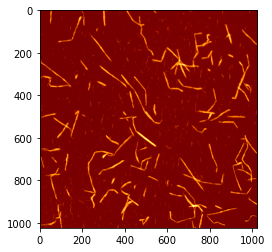

50pass.001


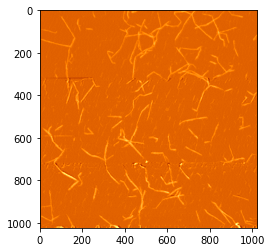

50pass.002


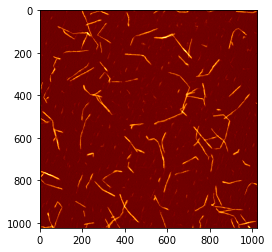

50pass.003


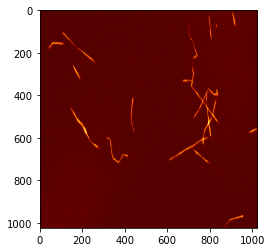

50pass.005


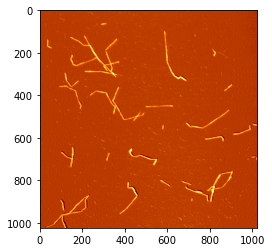

50pass.006


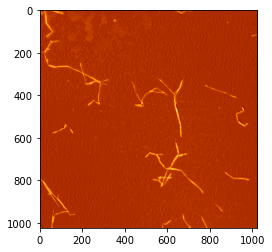

50pass.007


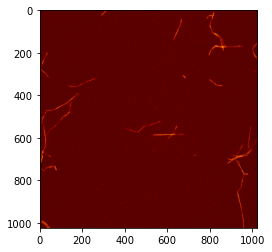

50pass.008


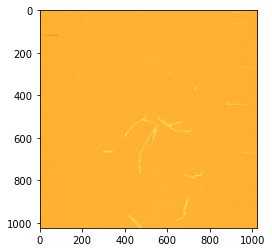

50pass.009


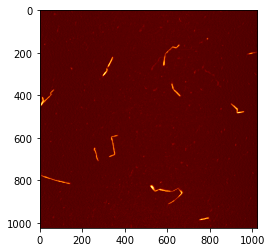

50pass.010


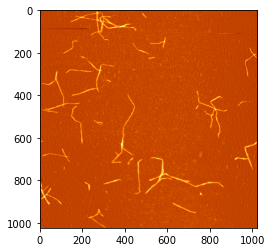

50pass.011


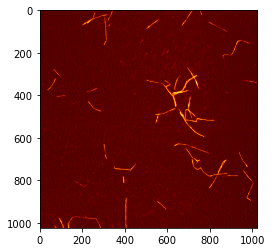

50pass.012


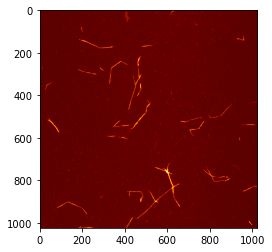

50pass.013


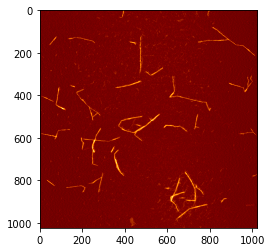

50pass.014


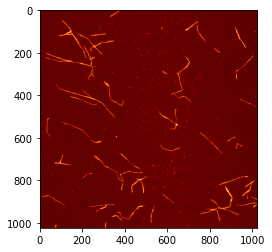

In [5]:
image_size = 1024
calibrated_image_list = []
for data_path in flist:
    print(data_path.stem)
    image = np.loadtxt(data_path, skiprows=1).reshape(image_size, image_size)
    calibrater = BG_Calibrater(image)
    calibrated_image = calibrater()
    
    calibrated_image_list.append(calibrated_image)
    
    plt.imshow(calibrated_image, cmap='afmhot')
    plt.show()

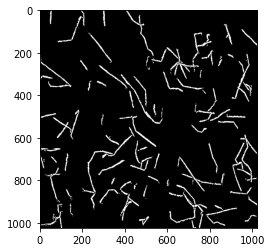

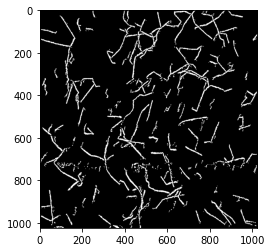

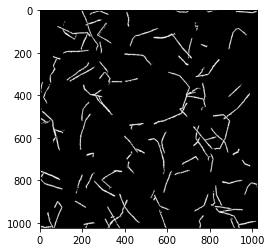

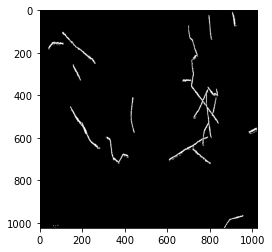

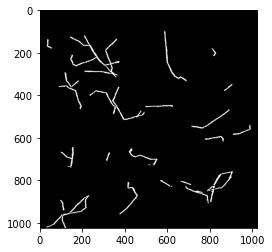

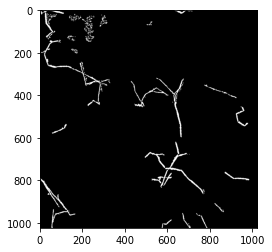

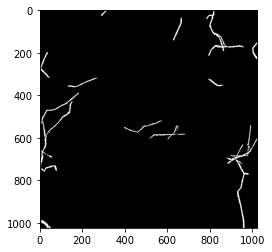

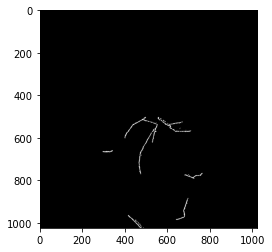

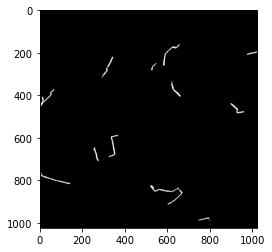

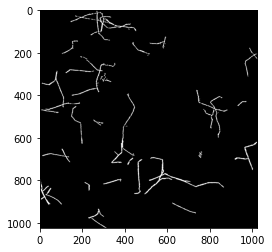

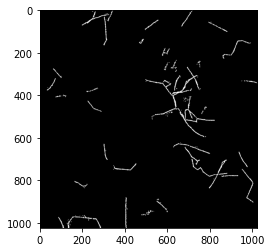

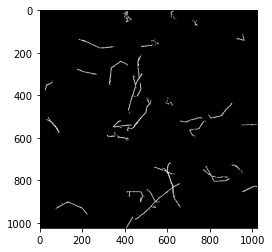

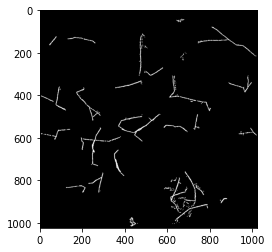

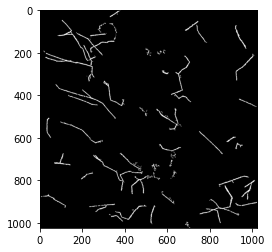

In [6]:
binary_image_list = []
for image in calibrated_image_list:
    segmentater = Segmentater(image)
    binary_image = segmentater()
    binary_image_list.append(binary_image)
    
    plt.imshow(binary_image, cmap='gray')
    plt.show()

In [43]:
a = np.arange(25).reshape(5,5)
print(id(a))
b = a[1:-1, 1:-1]
print(id(b))
b[1,1] = 0
print(id(b))
a

2978838536912
2978838536528
2978838536528


array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11,  0, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [55]:
a = np.array([[0,1,0,0]
             ,[0,0,0,1]
             ,[1,0,0,0]
             ,[0,0,0,1]]).astype(bool)
a[np.where(a)]

array([ True,  True,  True,  True])

In [ ]:
def AFM_nanoindentation(F, Poisson, Young_GPa=30, TipR_nm=2)